In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Loading

In [47]:
# Loading CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Preprocessing

In [48]:
# Train, Val, Test data spliting
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [49]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [50]:
# Converting integer labels to one-hot encoded format
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [51]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [52]:
base_model_1 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

94765736/94765736 [==============================] - 1s 0us/step


### Model Definition

In [65]:
# Decide which layers to freeze/unfreeze
# Freeze the convolutional layers up to a certain point

freeze_until_layer = 'conv5_block2_out'
for layer in base_model_1.layers:
    layer.trainable = False
    if layer.name == freeze_until_layer:
        break

count_freeze_layers = 0
for layer in base_model_1.layers:
    if layer.trainable == False:
      count_freeze_layers += 1


print("Total layers in Base Model: ", str(len(base_model_1.layers)))
print("Total Freeze layers in Base Model: ", str(count_freeze_layers))


Total layers in Base Model:  175
Total Freeze layers in Base Model:  165


In [66]:
# Sequential Model
# Adding the base_model_1 (pre-trained model) as the first layer
# Flatten the output from the pre-trained model

model_1= Sequential()
model_1.add(base_model_1)
model_1.add(Flatten())
model_1.add(Dense(1024,activation=('relu'),input_dim=512))  # Note: The input dimension is set to 512, assuming that the pre-trained model has 512 output features
model_1.add(Dense(512,activation=('relu')))
model_1.add(Dropout(0.2))
model_1.add(Dense(256,activation=('relu')))
model_1.add(Dropout(0.2))
model_1.add(Dense(128,activation=('relu')))
model_1.add(Dense(10,activation=('softmax')))  # Output layer with 10 units for 10 classes and softmax activation

In [67]:
# model summary
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)              

### Model Training

In [68]:
batch_size = 100
epochs = 10

In [69]:
# Compile the model
# During model compiling we consider optimizer, loss function, and the metrics that need to be evaluated during the test and train processes.
# We specify the loss as categoricl_crossentropy since the labels are one-hot encoded. IF we had integer labels then we'd have to use sparse_categorical_crossentropy as loss function.
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Model Prediction

In [70]:
# Train the model using the training data (x_train, y_train)
# Verbose = 1 means to show progress bar with training information
history_model_1 = model_1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val,y_val), verbose=1)


Epoch 1/10
350/350 [==============================] - 16s 31ms/step - loss: 0.5344 - accuracy: 0.8400 - val_loss: 0.9193 - val_accuracy: 0.7533
Epoch 2/10
350/350 [==============================] - 10s 28ms/step - loss: 0.4904 - accuracy: 0.8516 - val_loss: 0.8436 - val_accuracy: 0.7489
Epoch 3/10
350/350 [==============================] - 9s 25ms/step - loss: 0.4450 - accuracy: 0.8575 - val_loss: 0.8242 - val_accuracy: 0.7513
Epoch 4/10
350/350 [==============================] - 9s 25ms/step - loss: 0.4329 - accuracy: 0.8592 - val_loss: 0.8287 - val_accuracy: 0.7551
Epoch 5/10
350/350 [==============================] - 9s 25ms/step - loss: 0.4231 - accuracy: 0.8615 - val_loss: 0.8465 - val_accuracy: 0.7535
Epoch 6/10
350/350 [==============================] - 9s 26ms/step - loss: 0.4133 - accuracy: 0.8629 - val_loss: 0.8331 - val_accuracy: 0.7560
Epoch 7/10
350/350 [==============================] - 9s 25ms/step - loss: 0.4065 - accuracy: 0.8646 - val_loss: 0.8450 - val_accuracy: 0.75

### Model Evaluation

In [84]:
# Evaluate the model
score = model_1.evaluate(x_val, y_val)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

469/469 [==============================] - 7s 12ms/step - loss: 0.9472 - accuracy: 0.7509
Test loss: 0.9471688866615295
Test accuracy: 0.7508666515350342


In [71]:
model_1.history.history

{'loss': [0.5344347953796387,
  0.49035513401031494,
  0.44498321413993835,
  0.43290045857429504,
  0.4231112599372864,
  0.4133259356021881,
  0.4064536392688751,
  0.3942824900150299,
  0.3977026343345642,
  0.3759589195251465],
 'accuracy': [0.8400285840034485,
  0.8515714406967163,
  0.857457160949707,
  0.8592000007629395,
  0.8615428805351257,
  0.8628857135772705,
  0.8646000027656555,
  0.868485689163208,
  0.873028576374054,
  0.871914267539978],
 'val_loss': [0.9193378686904907,
  0.843583345413208,
  0.8242119550704956,
  0.8287450671195984,
  0.8464910387992859,
  0.8330538868904114,
  0.8450214266777039,
  0.8569287657737732,
  0.9731181263923645,
  0.9471683502197266],
 'val_accuracy': [0.753333330154419,
  0.7488666772842407,
  0.7512666583061218,
  0.7550666928291321,
  0.7534666657447815,
  0.7559999823570251,
  0.7528666853904724,
  0.7534666657447815,
  0.7513999938964844,
  0.7508666515350342]}

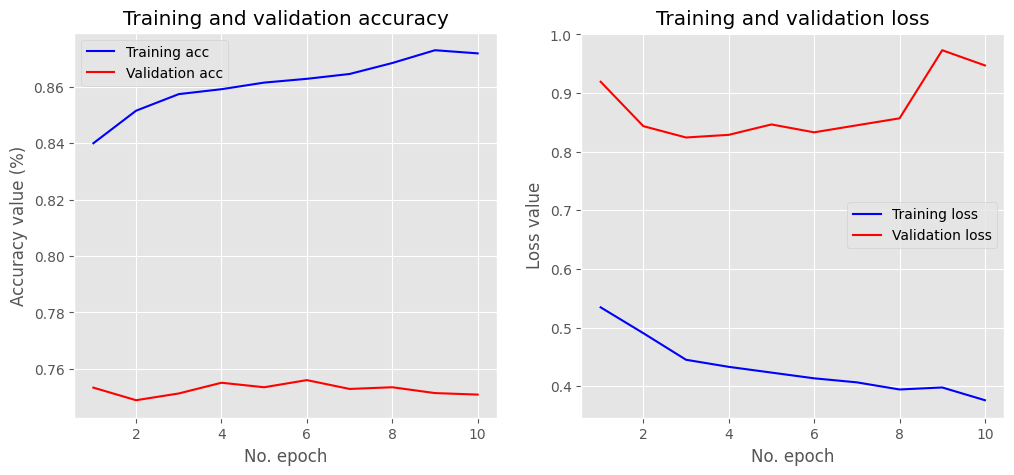

In [73]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

plot_history(history_model_1)

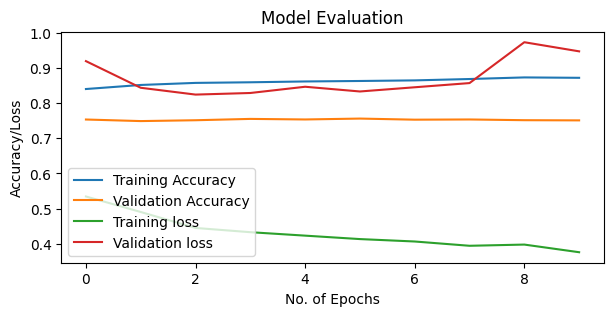

In [85]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history_model_1.history["accuracy"])
plt.plot(history_model_1.history["val_accuracy"])
plt.plot(history_model_1.history["loss"])
plt.plot(history_model_1.history["val_loss"])
plt.title("Model Evaluation")
plt.ylabel("Accuracy/Loss")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [79]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [80]:
y_pred=model_1.predict(x_test)
y_true=np.argmax(y_test,axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

313/313 [==============================] - 5s 10ms/step


In [81]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

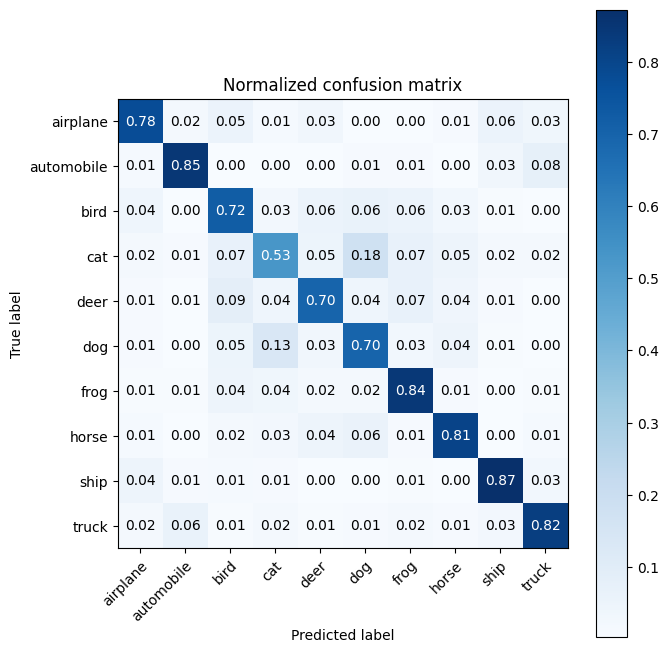

In [82]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True, title='Normalized confusion matrix')

### Model from Scratch

In [44]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and feed it into dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [45]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 21s 12ms/step - loss: 2.0366 - accuracy: 0.4542 - val_loss: 1.2234 - val_accuracy: 0.5661
Epoch 2/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.2414 - accuracy: 0.5684 - val_loss: 1.1725 - val_accuracy: 0.5945
Epoch 3/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.1076 - accuracy: 0.6180 - val_loss: 1.1013 - val_accuracy: 0.6246
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9908 - accuracy: 0.6588 - val_loss: 1.0255 - val_accuracy: 0.6514
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.9092 - accuracy: 0.6871 - val_loss: 1.0531 - val_accuracy: 0.6419
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.8152 - accuracy: 0.7204 - val_loss: 1.0560 - val_accuracy: 0.6583
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/step - loss: 0.7355 - accuracy: 0.7472 - val_loss: 1.1094 -

In [46]:
# Evaluate the model
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

313/313 [==============================] - 1s 4ms/step - loss: 1.3514 - accuracy: 0.6562
Test loss: 1.3513758182525635
Test accuracy: 0.6561999917030334
